In [ ]:
! pip install pymysql

Install Python 3.9.13

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
from sklearn.svm import SVR, NuSVR
from sklearn.pipeline import make_pipeline

# Grab Dataset

In [2]:
ysi = pd.read_csv("../datasets/Colorado/ysi_dataset.csv")
weather = pd.read_csv("../datasets/Colorado/weather_dataset.csv")
# convert to date time and round ysi to nearest 15 mins
ysi['datetime'] = pd.to_datetime(ysi['datetime']).dt.round('15min')
weather['datetime'] = pd.to_datetime(weather['datetime'])

In [3]:
# combine both DF's on datetime
combined = pd.merge(ysi, weather, on='datetime')
combined.reset_index(drop=True, inplace=True)
combined = combined.drop(columns=['experimentid_y'])
#combined = pd.read_csv("../datasets/Colorado/best_50_days_data.csv")
combined.columns

Index(['datetime', 'experimentid_x', 'ph', 'temperature_oc',
       'par_umol_photons_m2_s', 'dissolved_oxygen_mg_l', 'airtemp_oc',
       'global_light_energy_w_m2', 'humid_rh', 'wdspd_m_s'],
      dtype='object')

# Data Visualization

In [405]:
# combined = combined.drop(combined[combined['ph'] < 5].index)
# combined = combined.drop(combined[combined['ph'] > 9].index)
# combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] < 2].index)
# combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] > 20].index)
# combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] < 3/100 * combined['global_light_energy_w_m2']].index)
# combined = combined.drop(combined[combined['dissolved_oxygen_mg_l'] >( 3/100 * combined['global_light_energy_w_m2']) + 15].index)

In [5]:
combined.to_csv("../datasets/do_combined.csv", index=False)

In [ ]:
feat = combined.sample(3000)
plt.plot(feat['temperature_oc'],feat['dissolved_oxygen_mg_l'], 'bo')
plt.ylabel("ph")
plt.xlabel("global_light_energy_w_m2")
plt.show()

# Feature Selection

In [ ]:
X = feat[['ph', 'temperature_oc', 'global_light_energy_w_m2', 'humid_rh']].values
y = feat['dissolved_oxygen_mg_l'].values
regressor = RandomForestRegressor(n_estimators=50)
regressor.fit(X, y)


print(regressor.feature_importances_)

model = SelectFromModel(regressor, prefit=True)
X_new = model.transform(X)

features selected: ph, temperature_oc, global_light_energy_w_m2, humid_rh
not considered: wdspd_m_s (low correlation), par_umol_photons_m2_s (duplicated),

# Training

In [4]:
# store all rows where temp is greater than 25 in splitted
#combined = pd.read_csv("../datasets/do_combined.csv")

combined['depth'] = 1.5
test = pd.DataFrame()


# ------------- Philadelphia Dataset --------------
phillydf = pd.read_csv("../datasets/Philly/phillycombined.csv")

# rename columns
phillydf = phillydf.rename(columns={"DO_mg_L": "dissolved_oxygen_mg_l", "time": "datetime", "Temp_deg_C": "temperature_oc", "relativehumidity_2m (%)": "humid_rh", "temperature_2m (°C)": "airtemp_oc", "diffuse_radiation (W/m²)": "global_light_energy_w_m2", "Depth_m": "depth"})

# drop columns
test = combined.tail(250)
phillydf = phillydf.tail(250)
phillydf['ph'] = 7
phillydf = phillydf.drop(columns=['Longitude','Unnamed: 0', 'Site', 'Latitude', 'DO_pct_Sat', 'DOLoggerType', 'roundedNearestHour', 'roundedNearestHour', 'precipitation (mm)', 'direct_radiation (W/m²)', 'surface_pressure (hPa)', 'windspeed_10m (km/h)'])
test = pd.concat([test, phillydf], ignore_index=True)


# fix the 23 to 0 jump
test['hour'] = pd.to_datetime(test['datetime']).dt.hour
test = test.dropna(subset=['hour'])
# test.loc[test['hour'] <= 12, 'hour'] = 12 - test.loc[test['hour'] <= 12, 'hour']
# test.loc[test['hour'] > 12, 'hour'] = test.loc[test['hour'] > 12, 'hour'] - 12
print(len(test))

test = test.dropna(subset=['hour', 'dissolved_oxygen_mg_l'], inplace=False)
X_train,X_test,y_train,y_test = train_test_split(test[['global_light_energy_w_m2', 'ph', 'temperature_oc', 'humid_rh', 'airtemp_oc','depth', 'hour']],
        test['dissolved_oxygen_mg_l'], test_size=0.15)

500


In [5]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

def stats(y_pred_all, y_test_all):
    # Calculate the R2 score
    r2 = r2_score(y_test_all, y_pred_all)

    print(f"R2 Score: {r2:.4f}")
    # Calculate MAE
    mae = mean_absolute_error(y_test_all, y_pred_all)

    # Calculate RMSE
    mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

# SVM

In [181]:
print("------------ Linear Regression ------------")
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)
stats(y_pred, y_test)

------------ Linear Regression ------------
R2 Score: 0.4224
Mean Absolute Error (MAE): 1.7512432187881901
Root Mean Squared Error (RMSE): 1.4601038186045974


In [8]:
from sklearn.linear_model import RidgeCV

print("------------ Spline SVR Results ------------")
svm_spline = make_pipeline(preprocessing.SplineTransformer(), SVR(kernel='rbf', shrinking=True, C=1.5))
svm_spline.fit(X_train, y_train)
y_pred = svm_spline.predict(X_test)
# save as pickle file
filename = './weights/do_svm_spline.pkl'
pickle.dump(svm_spline, open(filename, 'wb'))
stats(y_pred, y_test)

print("------------ Quantile SVR Results ------------")
svm_q = make_pipeline(preprocessing.QuantileTransformer(), SVR(kernel='rbf', shrinking=True, C=1.5))
svm_q.fit(X_train, y_train)
y_pred = svm_q.predict(X_test)
stats(y_pred, y_test)

print("------------ Robust SVR Results ------------")
svm_robust = make_pipeline(preprocessing.MinMaxScaler(), SVR(kernel='rbf', shrinking=True, C=1.5))
svm_robust.fit(X_train, y_train)
y_pred = svm_robust.predict(X_test)
# save as pickle file
filename = './weights/do_svm_robust.pkl'
pickle.dump(svm_robust, open(filename, 'wb'))
stats(y_pred, y_test)

print("------------ Minmax SVR Results ------------")
svm_minmax = make_pipeline(preprocessing.MinMaxScaler(), SVR(kernel='rbf', shrinking=True, C=1.5))
svm_minmax.fit(X_train, y_train)
y_pred = svm_minmax.predict(X_test)
stats(y_pred, y_test)

# print("------------ Stacking Results ------------")
# from sklearn.ensemble import BaggingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import StackingRegressor
# svm_stack = StackingRegressor(estimators=[
#     ('svr', svm_spline), 
#     ('svr2', svm_robust),
#     ('svr3', svm_robust),
#     ('svr4', svm_spline),
#     ('svr5', svm_robust),
#     ('svr6', svm_spline),
#     ('svr7', svm_spline),
#     ('bag', model),
#     ('bag2', model)
# ])

# svm_stack.fit(X_train, y_train)
# y_pred = svm_stack.predict(X_test)
# stats(y_pred, y_test)

print("------------ Weighted Stacking Results ------------")
from sklearn.ensemble import StackingRegressor
class WeightedStackingRegressor(StackingRegressor):
    def __init__(self, estimators, final_estimator=RidgeCV(), cv=None, 
                 n_jobs=None, passthrough=False, verbose=0, weights=None):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
        self.n_jobs = n_jobs
        self.passthrough = passthrough
        self.verbose = verbose
        self.weights = weights or {}
        super().__init__(estimators=estimators, final_estimator=final_estimator, cv=cv, 
                            n_jobs=n_jobs, passthrough=passthrough, verbose=verbose)
        
    def predict(self, X, **predict_params):
        predictions = [
            estimator.predict(X) for estimator in self.estimators_
        ]
        weighted_predictions = sum(
            self.weights.get(name, 1) * prediction for name, prediction in zip(self.named_estimators_.keys(), predictions)
        )
        normalized_predictions = weighted_predictions / sum(self.weights.values())
        
        return normalized_predictions

from sklearn.linear_model import Ridge
ridge = make_pipeline(preprocessing.SplineTransformer(), Ridge())
svm_weighted = WeightedStackingRegressor(estimators=[('svr', svm_spline), ('svr2', svm_robust), ('ridge', ridge)], 
                    weights={'svr': 5.2, 'svr2': 4.8, 'ridge': 1.7})
svm_weighted.fit(X_train, y_train)
y_pred = svm_weighted.predict(X_test)
stats(y_pred, y_test)


# print('------------ Inhouse Stacking Results ------------')
# def custom_stacking_predict(X, weights={'svm_spline': 4, 'svm_robust': 3, 'model': 2}):
#     # Extract weights
#     w_svm_spline = weights['svm_spline']
#     w_svm_robust = weights['svm_robust']
#     w_model = weights['model']
    
#     # Predictions
#     pred_svm_spline = svm_spline.predict(X)
#     pred_svm_robust = svm_robust.predict(X)
#     pred_model = model.predict(X)
    
#     # Weighted sum
#     total_predictions = (w_svm_spline * pred_svm_spline +
#                          w_svm_robust * pred_svm_robust +
#                          w_model * pred_model)
    
#     # Normalize by the sum of weights
#     normalized_predictions = total_predictions / sum(weights.values())
    
#     return normalized_predictions

# # Example usage
# y_pred = custom_stacking_predict(X_test)
# stats(y_pred, y_test)

------------ Spline SVR Results ------------
R2 Score: 0.9623
Mean Absolute Error (MAE): 0.5222119965306056
Root Mean Squared Error (RMSE): 1.0111442229309202
------------ Quantile SVR Results ------------
R2 Score: 0.9026
Mean Absolute Error (MAE): 0.9392691039856311
Root Mean Squared Error (RMSE): 1.2823508576649543
------------ Robust SVR Results ------------
R2 Score: 0.9470
Mean Absolute Error (MAE): 0.7248045153214557
Root Mean Squared Error (RMSE): 1.1011113078455883
------------ Minmax SVR Results ------------
R2 Score: 0.9470
Mean Absolute Error (MAE): 0.7248045153214557
Root Mean Squared Error (RMSE): 1.1011113078455883
------------ Weighted Stacking Results ------------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (425). n_quantiles is set to n_samples.
  warnings.warn(


NameError: name 'StackingRegressor' is not defined

# Other Made

In [7]:
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor

# Bayesian Ridge Regression
print("------------ Bayesian Ridge Regression Results ------------")
bayesian_ridge = make_pipeline(preprocessing.QuantileTransformer(), BayesianRidge())
bayesian_ridge.fit(X_train, y_train)
y_pred = bayesian_ridge.predict(X_test)
stats(y_pred, y_test)

# Huber Regression
print("------------ Huber Regression Results ------------")
huber_reg = make_pipeline(preprocessing.SplineTransformer(), HuberRegressor())
huber_reg.fit(X_train, y_train)
y_pred = huber_reg.predict(X_test)
stats(y_pred, y_test)

# Ridge Regression
print("------------ Ridge Regression Results ------------")
ridge = make_pipeline(preprocessing.SplineTransformer(), Ridge())
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
# save as pickle file
filename = './weights/do_ridge.pkl'
pickle.dump(ridge, open(filename, 'wb'))
stats(y_pred, y_test)


------------ Bayesian Ridge Regression Results ------------
R2 Score: 0.4710
Mean Absolute Error (MAE): 3.220640325662405
Root Mean Squared Error (RMSE): 1.9575118617089258
------------ Huber Regression Results ------------
R2 Score: 0.9794
Mean Absolute Error (MAE): 0.4928928179218924
Root Mean Squared Error (RMSE): 0.8693949058582924
------------ Ridge Regression Results ------------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (425). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


R2 Score: 0.9721
Mean Absolute Error (MAE): 0.5660134914537803
Root Mean Squared Error (RMSE): 0.938334983009751


# Tree Based

In [12]:
print("------------ Bagging Results ------------")
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
base_estimator = DecisionTreeRegressor()
bag_pipe = make_pipeline(preprocessing.SplineTransformer(), BaggingRegressor(base_estimator=base_estimator, n_estimators=10, n_jobs=5))
bag_pipe.fit(X_train, y_train)
y_pred = bag_pipe.predict(X_test)
stats(y_pred, y_test)

print("------------ Stacking Results ------------")
from sklearn.ensemble import StackingRegressor
model = StackingRegressor(estimators=[
    ('bag', BaggingRegressor(n_jobs=5)),
    ('n1', MLPRegressor(hidden_layer_sizes=(2,3), activation='relu')),
    ('n2', MLPRegressor(hidden_layer_sizes=(3,2), activation='tanh'))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

------------ Bagging Results ------------
R2 Score: 0.9534
Mean Absolute Error (MAE): 0.44896000000000014
Root Mean Squared Error (RMSE): 0.97446160106031
------------ Stacking Results ------------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multi

R2 Score: 0.9685
Mean Absolute Error (MAE): 0.39649786552572713
Root Mean Squared Error (RMSE): 0.8834656637816597


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [68]:
print("------------ Random Forest Results ------------")
rf_regressor = make_pipeline(preprocessing.SplineTransformer(), RandomForestRegressor(n_estimators=24, max_depth=20))
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
stats(y_pred, y_test)

print("------------ Decision Tree Results ------------")
from sklearn.tree import DecisionTreeRegressor
d_tree = DecisionTreeRegressor(max_depth=24)
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
stats(y_pred, y_test)

print("------------ XG Boost Results ------------")
from sklearn.ensemble import GradientBoostingRegressor
xg_boost = GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')
xg_boost.fit(X_train, y_train)
y_pred = xg_boost.predict(X_test)
stats(y_pred, y_test)


------------ Random Forest Results ------------
R2 Score: 0.9569
Mean Absolute Error (MAE): 0.4307499999999997
Root Mean Squared Error (RMSE): 0.9556343405364125
------------ Poly Regression Results ------------
R2 Score: -15.9055
Mean Absolute Error (MAE): 7.338743931632877
Root Mean Squared Error (RMSE): 4.252534489605153
------------ Decision Tree Results ------------
R2 Score: 0.9635
Mean Absolute Error (MAE): 0.42600000000000005
Root Mean Squared Error (RMSE): 0.9166367799057946
------------ XG Boost Results ------------
R2 Score: 0.9636
Mean Absolute Error (MAE): 0.3793288846448886
Root Mean Squared Error (RMSE): 0.9162147306691887


# Deep Learning

In [ ]:
model = nn.Sequential(
    nn.Linear(3, 16),
    nn.CELU(),
    nn.Linear(16, 16),
    nn.CELU(),
    nn.Linear(16, 4),
    nn.CELU(),
    nn.Linear(4, 1)
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.numeric_columns = ['log_temperature_oc_global_light_energy_w_m2', 'log_ph_global_light_energy_w_m2', 'wdspd_m_s_airtemp_oc_ph']
        self.transformer = preprocessing.QuantileTransformer()
        transformed_data = self.transformer.fit_transform(dataframe[self.numeric_columns].values)
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['dissolved_oxygen_mg_l']).reset_index(drop=True)

    def __len__(self):
        return len(self.data)
    
    def getInverseTransform(self, inputs):
        return self.quantile_transformer.inverse_transform(inputs)

    def __getitem__(self, idx):
        inputs = self.data[self.numeric_columns].iloc[idx].values.astype(np.float32)
        label = self.data['dissolved_oxygen_mg_l'].iloc[idx].astype(np.float32)
        inputs = torch.tensor(inputs)
        label = torch.tensor(label)
        return inputs, label


In [ ]:
loss_fn = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
num_epochs = 10

splitted = pd.read_csv("../datasets/Philly/new_features.csv")
test = splitted.copy(True)
trainset, testset = train_test_split(test, test_size=0.1)

data_loader = DataLoader(MyDataset(trainset), shuffle=True)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # Reshape labels to match the shape of outputs
        labels = labels.view(outputs.shape)

        loss = loss_fn(outputs , labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(data_loader)
    # Print the loss for each epoch
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")
# Training complete

In [ ]:
# save weights
torch.save(model.state_dict(), './weights/weights2.sav')
model.load_state_dict(torch.load('./weights/weights2.sav'))

# weights 1 : loss = 30.98
# weights 2 : loss = 1.1218

# Evaluation

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true and predicted values
y_test_all = []
y_pred_all = []

newset = pd.merge(ysi, weather, on='datetime').sample(1000)

dataset = MyDataset(testset)
data_loader = DataLoader(dataset)

# Disable gradient calculation
with torch.no_grad():
    for inputs, label in data_loader:

        # Forward pass to get predictions
        y_pred = model(inputs)

        # Convert the predictions and targets to numpy arrays
        y_pred_np = y_pred.numpy()
        label_np = label.numpy()
        #print(dataset.quantile_transformer.inverse_transform(inputs.numpy()))
        #print(f"actual: { y_pred.item():3f} predicted: {label.item():3f}")

        # Append batch results to the overall lists
        y_test_all.append(label_np)
        y_pred_all.append(y_pred_np)

# Concatenate the lists into a single array
y_test_all = np.concatenate(y_test_all)
y_pred_all = np.concatenate(y_pred_all)

# Calculate the R2 score
r2 = r2_score(y_test_all, y_pred_all)

print(f"R2 Score: {r2:.4f}")
# Calculate MAE
mae = mean_absolute_error(y_test_all, y_pred_all)

# Calculate RMSE
mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

# Pre - Trained Models

In [ ]:
play = nn.Sequential(
    nn.Linear(4, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 1)
)

play.load_state_dict(torch.load('weights.sav'))

# Save Weights

In [ ]:
# Dictionary Approach 

model_dict = dict()
model_dict['splineSVM'] = clf_rbf_nusvm_spline
model_dict['quantileSVM'] = clf_rbf_svm_q
model_dict['robustSVM'] = clf_rbf_nusvm_minmax
model_dict['stackingSVM'] = clf_stack
model_dict['bagging'] = bag_pipe

In [174]:
import tarfile
import json
import io

# Save the trained model
model_filename = './weights/do_svm_weighted.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svm_weighted, file)

# Load the saved model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

y_pred = loaded_model.predict(X_test)
stats(y_pred, y_test)

# Specify the name of the pickle file and the .mar archive file
mar_filename = 'model_archive.mar'

# # Create a new tar archive
# with tarfile.open(mar_filename, 'w') as archive:
#     # Add the pickle file to the archive
#     archive.add(model_filename)

# # Create a manifest file with the required metadata
# manifest = {'model-file': model_filename, 'model-name': 'RandomForestRegressor'}

# # Add the manifest file to the archive
# with tarfile.open(mar_filename, 'a') as archive:
#     manifest_string = json.dumps(manifest)
#     manifest_bytes = manifest_string.encode('utf-8')
#     manifest_file = tarfile.TarInfo('MANIFEST')
#     manifest_file.size = len(manifest_bytes)
#     archive.addfile(manifest_file, io.BytesIO(manifest_bytes))


R2 Score: 0.9395
Mean Absolute Error (MAE): 0.7414966517914219
Root Mean Squared Error (RMSE): 1.1049055093927238


# Check performance on DB values

In [250]:
import pymysql

# Connect to the database
connection = pymysql.connect(
    host='localhost', 
    user='root', 
    password='N@wid2003', 
    db='dma_iot_morefish_spark_farms_v3'
)

# Create a cursor object
cursor = connection.cursor()

# Get the latest data from the database and store it in a pandas dataframe
query = "SELECT dvd_ph, dvd_temp, dvd_updated_at, dvd_do FROM device_devicedata WHERE dvd_ph > 0 AND dvd_temp > 0 AND dvd_dev_id = 2 ORDER BY dvd_updated_at ASC"
df = pd.read_sql(query, connection)

# Close the connection
connection.close()
len(df)

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


778

In [3]:
df = pd.read_csv("../datasets/Sensor-predict/spark-july-16.csv")

In [4]:
df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime', 'dvd_do': 'do_linreg'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
df['datetime'] = pd.to_datetime(df['datetime'])
# spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather = pd.read_csv("../datasets/Sensor-predict/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather, left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp'}, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])

In [18]:
x_train = pd.DataFrame()
df['depth'] = 1.2192
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
#df.loc[df['hour'] <= 12, 'hour'] = 12 - df.loc[df['hour'] <= 12, 'hour']
#df.loc[df['hour'] > 12, 'hour'] = df.loc[df['hour'] > 12, 'hour'] - 12
x_train = df[['global_light_energy_w_m2', 'ph', 'temperature_oc', 'humid_rh', 'airtemp_oc','depth', 'hour']]

# test the neural net model and store its result in the pandas df
'''
y_test_all = []
y_pred_all = []

dataset = MyDataset(x_train)
data_loader = DataLoader(dataset)

# Disable gradient calculation
with torch.no_grad():
    for inputs, label in data_loader:

        # Forward pass to get predictions
        y_pred = model(inputs)

        # Convert the predictions and targets to numpy arrays
        y_pred_np = y_pred.numpy()
        y_pred_all.append(y_pred_np)

# Concatenate the lists into a single array
y_pred_all = np.concatenate(y_pred_all)
df['DeepNN'] = y_pred_all
'''


"\ny_test_all = []\ny_pred_all = []\n\ndataset = MyDataset(x_train)\ndata_loader = DataLoader(dataset)\n\n# Disable gradient calculation\nwith torch.no_grad():\n    for inputs, label in data_loader:\n\n        # Forward pass to get predictions\n        y_pred = model(inputs)\n\n        # Convert the predictions and targets to numpy arrays\n        y_pred_np = y_pred.numpy()\n        y_pred_all.append(y_pred_np)\n\n# Concatenate the lists into a single array\ny_pred_all = np.concatenate(y_pred_all)\ndf['DeepNN'] = y_pred_all\n"

In [92]:
df.columns

Index(['Unnamed: 0', 'ph', 'temperature_oc', 'datetime', 'do_linreg',
       'dvd_dev_id', 'date', 'rounded_datetime', 'airtemp_oc', 'humid_rh',
       'precipitation (mm)', 'surface_pressure (hPa)', 'windspeed_10m (km/h)',
       'global_light_energy_w_m2', 'depth', 'hour', 'Robust', 'Spline',
       'clfstack', 'model', 'weighted', 'RF', 'XG', 'Minmax', 'bag', 'huber',
       'bridge'],
      dtype='object')

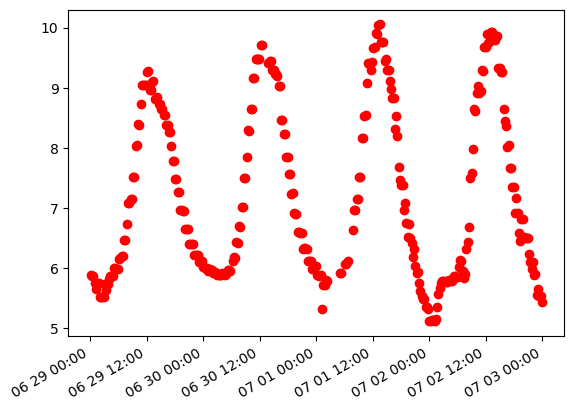

In [193]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
bet = df.loc[df['datetime'].between('2023-06-29', '2023-07-03')]

#ax.plot(bet['datetime'], bet['huber'].astype(float), 'bo')
ax.plot(bet['datetime'], bet['weighted'].astype(float), 'ro')
#ax.plot(bet['datetime'], (bet['global_light_energy_w_m2'].astype(float)/65 + 5), 'c')
myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()
plt.show()

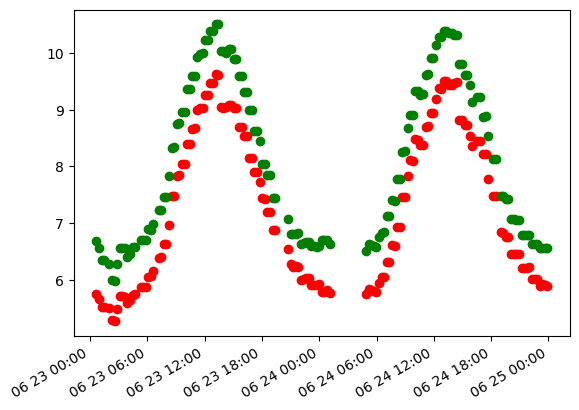

In [191]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# y_pred = huber_reg.predict(x_train)
# df['huber'] = y_pred

# y_pred = ridge.predict(x_train)
# df['ridge'] = y_pred

y_pred = svm_spline.predict(x_train)
df['Spline'] = y_pred

# y_pred = custom_stacking_predict(x_train, weights={'svm_spline': 5, 'svm_robust': 2, 'model': 3})
# y_pred = svm_stack.predict(x_train)
# df['clfstack'] = y_pred

y_pred = svm_weighted.predict(x_train)
df['weighted'] = y_pred


fig, ax = plt.subplots()
bet = df.loc[df['datetime'].between('2023-06-23', '2023-06-25')]

ax.plot(bet['datetime'], bet['weighted'].astype(float), 'ro')
ax.plot(bet['datetime'], bet['Spline'].astype(float), 'go')
#ax.plot(bet['datetime'], bet['Robust'].astype(float), 'bo')
#ax.plot(bet['datetime'], bet['clfstack'].astype(float), 'yo')

myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()
plt.show()

# Local Data

In [ ]:
bd_data = pd.read_csv("../datasets/GEMStat/India-Lake-2023-07-04_13-45/samples.csv", sep=';')

# Combine 'Date' and 'Time' columns into a single column
bd_data['datetime'] = pd.to_datetime(bd_data['Date'] + ' ' + bd_data['Time'], format='%Y-%m-%d %H:%M')

# Drop the original 'Date' and 'Time' columns if no longer needed
bd_data.drop(['Date', 'Time'], axis=1, inplace=True)

# Merge by datetime and LocationID
new_bd_data = pd.DataFrame()
new_bd_data[['LocationID','datetime', 'O2-Dis', ]] = bd_data[bd_data['Parameter'] == 'O2-Dis'][['LocationID', 'datetime','Value']]

print(bd_data.columns)

new_bd_data = pd.merge(new_bd_data, bd_data[bd_data['Parameter'] == 'pH'][['datetime', 'Value', 'LocationID']], on=['datetime', 'LocationID'], how='right')
new_bd_data = pd.merge(new_bd_data, bd_data[bd_data['Parameter'] == 'TEMP'][['datetime', 'Value', "LocationID"]], on=['datetime','LocationID'], how='right')

new_bd_data.rename(columns={'O2-Dis': 'dissolved_oxygen_mg_l', 'Value_x': 'ph', 'Value_y': 'temperature_oc'}, inplace=True)

print(len(new_bd_data))
new_bd_data.sample(10)

# Combine with Ammonia


In [ ]:
from sklearn.ensemble import RandomForestClassifier

cis = pd.read_csv("../datasets/upsampled_data.csv")
test = cis.copy(True)
X_train,X_test,y_train,y_test = train_test_split(test[['DO_MGL','PH','precipitation (mm)','pressure_msl (hPa)', 'direct_radiation (W/m²)']], 
        test['decreaseFeed'], test_size=0.001)

# Training
clf = RandomForestClassifier(max_depth=40, criterion='gini', max_features='log2')
clf.fit(X_train, y_train)

In [ ]:
# Testing
'''
1. Remove outliers greater than 2 std devs on df
2. Impute missing values with median
3. Apply StandardScaler to DO, PH, pressure, direct radiation
'''
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#imputer = SimpleImputer(strategy='median')
#df = imputer.fit_transform(df)
nh4_test = df.copy(True)
scaler = StandardScaler()
nh4_test[['RF', 'ph', 'pressure_msl (hPa)', 'direct_radiation (W/m²)']] = scaler.fit_transform(nh4_test[['RF', 'ph', 'pressure_msl (hPa)', 'direct_radiation (W/m²)']])

amm_pred = clf.predict(nh4_test[['RF', 'ph', 'precipitation (mm)', 'pressure_msl (hPa)', 'direct_radiation (W/m²)']])
df['ammonia'] = amm_pred



In [ ]:
print(df.sample(10))
df.to_csv('../datasets/ammonia_preds.csv', index=False)
